# Your first nonlinear transient solver- nonlinear diffusion

- [x] newton-raphson method
- [x] weak form
- [x] residual and jacobian
- [x] nonlinear iteration
- [x] time stepping
- [x] convergence criterion
- [x] nonlinear diffusion equation

Author: Yang Bai @ M3 Group

Date  : 2022.06.04

QQ group: 628204857

# Governing equation

$$\frac{\partial c}{\partial t}=\nabla\cdot(D(c)\nabla c)+f(c)$$, with $-D\nabla c\cdot\vec{n}=j_{0}$

## Weak form

$$\int_{\Omega}\dot{c}\delta c dV=\int_{\partial\Omega}D(c)\nabla c\cdot\vec{n}\delta c dS-\int_{\Omega}D\nabla c\nabla\delta cdV+\int_{\Omega}f(c)\delta c dV$$

### Residual
$$R_{c}^{I}=\int_{\Omega}\dot{c}N^{I}dV+\int_{\Omega}D(c)\nabla c\nabla N^{I}dV-\int_{\Omega}f(c)N^{I}dV+\int_{\partial\Omega}j_{0}N^{I}dS$$

### Jacobian
$$\begin{aligned}
K_{cc}^{IJ}&=-\frac{\partial R_{c}^{I}}{\partial c^{J}}\\
&=-\int_{\Omega}\frac{\partial\dot{c}}{\partial c}N^{J}N^{I}dV\\
&-\int_{\Omega}\frac{\partial D(c)}{\partial c}N^{J}\nabla c\nabla N^{I} dV
-\int_{\Omega}D(c)\nabla N^{J}\nabla N^{I}dV\\
&+\int_{\Omega}\frac{\partial f(c)}{\partial c}N^{J}N^{I}dV
\end{aligned}
$$

write result to nldiff-000000.vtu
step=     1, dt=   2.00000e-03, total time=   2.00000e-03
    iters=  1, |R0 |=   1.13069e-01, |R |=   1.13069e-01
    iters=  2, |R0 |=   1.13069e-01, |R |=   2.12859e-05
    iters=  3, |R0 |=   1.13069e-01, |R |=   2.16693e-11
step=     2, dt=   2.00000e-03, total time=   4.00000e-03
    iters=  1, |R0 |=   1.12965e-01, |R |=   1.12965e-01
    iters=  2, |R0 |=   1.12965e-01, |R |=   7.48628e-06
    iters=  3, |R0 |=   1.12965e-01, |R |=   3.05335e-12
step=     3, dt=   2.00000e-03, total time=   6.00000e-03
    iters=  1, |R0 |=   1.12959e-01, |R |=   1.12959e-01
    iters=  2, |R0 |=   1.12959e-01, |R |=   5.44658e-06
    iters=  3, |R0 |=   1.12959e-01, |R |=   5.76423e-13
step=     4, dt=   2.00000e-03, total time=   8.00000e-03
    iters=  1, |R0 |=   1.12971e-01, |R |=   1.12971e-01
    iters=  2, |R0 |=   1.12971e-01, |R |=   4.95716e-06
    iters=  3, |R0 |=   1.12971e-01, |R |=   1.79581e-13
step=     5, dt=   2.00000e-03, total time=   1.00

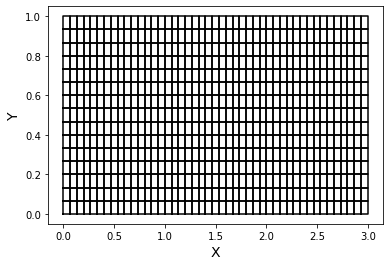

In [1]:
from FEToy.mesh.lagrange2dmesh import mesh2d
from FEToy.fe.shapefun import shape2d
from FEToy.fe.gaussrule import gausspoint2d
### for surface integration
from FEToy.mesh.lagrange1dmesh import mesh1d
from FEToy.fe.shapefun import shape1d
from FEToy.fe.gaussrule import gausspoint1d
### for result output
from FEToy.postprocess.Result import ResultIO
import numpy as np

# define your mesh
mymesh=mesh2d(xmax=3.0,ymax=1.0,nx=45,ny=15,meshtype='quad4')
mymesh.createmesh()
mymesh.plotmesh()

# define your shape function
shp=shape2d(meshtype='quad4')
shp.update()
# for surface integration
shp1d=shape1d(meshtype='edge2')
shp1d.update()

# define your gauss points
qpoints=gausspoint2d(ngp=2)
qpoints.creategausspoint()
# for surface integration
qpoints1d=gausspoint1d(ngp=2)
qpoints1d.creategausspoint()

#################################################
### defines your physical parameters here
#################################################
D0=1.0e0
j0=-0.02
def D(x):
    return D0*(1.0+0.8*np.sin(x*np.pi))
def dD(x):
    return D0*0.8*np.cos(x*np.pi)*np.pi
    # return 2*x
### for f
def f(x):
    return 1.0+10.0*x*x
def df(x):
    return 20.0*x

# define your K and rhs, and other vectors
nDofs=mymesh.nodes*1
K   =np.zeros((nDofs,nDofs))
R   =np.zeros(nDofs)
C   =np.zeros(nDofs) # solution of current step
Cold=np.zeros(nDofs) # solution of previous step
penalty=1.0e16 # for dirichlet bc

#################################################
### for time stepping and NR iteration
#################################################
### for time stepping
dt=2.0e-3     # time step size
totalstep=50 # total time step
### for NR iteration
tolerance=1.0e-10;reltol=1.0e-15 # absolute tolerenace and relative tolerance
maxiters=50
rnorm=1.0;rnorm0=1.0;iters=0 # init
converged=False

### for result output
result=ResultIO('nldiff')
result.save2vtu(mesh=mymesh,solution=C,varnamelist=['c'],step=0) # for initial configuration
interval=5 # output per 5-steps

gradc=np.zeros(2)
for step in range(1,totalstep):
    C[:]=Cold[:]
    iters=0;converged=False
    # now we can do the newton-raphson iteration
    print('step=%6d, dt=%14.5e, total time=%14.5e'%(step,dt,dt*step))
    while iters<maxiters and (not converged):
        K[:,:]=0.0;R[:]=0.0 # init
        # do the element loop
        for e in range(mymesh.elements):
            elconn=mymesh.elementconn[e,:]
            nodes=mymesh.nodecoords[elconn]
            for gp in range(qpoints.ngp2):
                xi =qpoints.gpcoords[gp,1]
                eta=qpoints.gpcoords[gp,2]
                w  =qpoints.gpcoords[gp,0]
                shp_val,shp_grad,j=shp.calc(xi,eta,nodes[:,0],nodes[:,1]) # xi,eta,x,y
                JxW=j*w # the weight times the determinate of jacobian transformation
                
                ###########################################################
                ### calc the physical quantities on current gauss point
                ###########################################################
                c   =0.0 # for the concentration on current gauss point
                cold=0.0 # for the concentration of previous step
                gradc[0]=0.0;gradc[1]=0.0 # gradient of concentration
                x=0.0;y=0.0 # coordinates of current gauss point
                for i in range(mymesh.nodesperelement):
                    iInd=elconn[i] # global id
                    c   +=shp_val[i]*C[iInd]
                    cold+=shp_val[i]*Cold[iInd]
                    gradc[0]+=shp_grad[i,0]*C[iInd]
                    gradc[1]+=shp_grad[i,1]*C[iInd]
                    x+=shp_val[i]*nodes[i,0]
                    y+=shp_val[i]*nodes[i,1]
                # here we use backward euler for the time integration
                cdot=(c-cold)/(dt) # for the concentration 'rate'
                dcdotdc=1.0/dt     # for \frac{\partial\dot{c}}{\partial c}
                for i in range(mymesh.nodesperelement):
                    iInd=elconn[i]
                    # assemble to residual
                    # R_{c}^{I}=\int_{\Omega}\dot{c}N^{I}dV
                    #          +\int_{\Omega}D(c)\nabla c\nabla N^{I}dV
                    #          -\int_{\Omega}f(c)N^{I}dV
                    #          +\int_{\partial\Omega}j_{0}N^{I}dS
                    R[iInd]+=cdot*shp_val[i]*JxW \
                            +D(c)*(gradc[0]*shp_grad[i,0]+gradc[1]*shp_grad[i,1])*JxW\
                            -f(c)*shp_val[i]*JxW
                    # now we can calculate the K matrix
                    for j in range(mymesh.nodesperelement):
                        jInd=elconn[j]
                        # K_{cc}^{IJ}&=-\frac{\partial R_{c}^{I}}{\partial c^{J}}\\
                        # =-\int_{\Omega}\frac{\partial\dot{c}}{\partial c}N^{J}N^{I}dV\\
                        #  -\int_{\Omega}\frac{\partial D(c)}{\partial c}N^{J}\nabla c\nabla N^{I} dV
                        #  -\int_{\Omega}D(c)\nabla N^{J}\nabla N^{I}dV\\
                        #  +\int_{\Omega}\frac{\partial f(c)}{\partial c}N^{J}N^{I}dV
                        K[iInd,jInd]+=(-1.0)*dcdotdc*shp_val[j]*shp_val[i]*JxW \
                                     +(-1.0)*dD(c)*shp_val[j]*(gradc[0]*shp_grad[i,0]+gradc[1]*shp_grad[i,1])*JxW \
                                     +(-1.0)*D(c)*(shp_grad[j,0]*shp_grad[i,0]+shp_grad[j,1]*shp_grad[i,1])*JxW \
                                     +(+1.0)*df(c)*shp_val[j]*shp_val[i]*JxW
            # end-of-gauss-point-loop
        # end-of-volume-element-loop
        #################################################
        ### now we need to apply the flux to 'bc' edge
        #################################################
#         ### here we apply the flux to 'right' edge
#         bcelmt=mymesh.bcconn['right'] # we want to apply the flux on the right side
#         for e in range(np.shape(bcelmt)[0]):
#             elconn=bcelmt[e,:]
#             nodes=mymesh.nodecoords[elconn,:]
#             for gp in range(qpoints1d.ngp):
#                 xi =qpoints1d.gpcoords[gp,1] # 1->xi, 2->eta
#                 w  =qpoints1d.gpcoords[gp,0] # weight
        
#                 shp_val,shp_grad,j=shp1d.calc(xi,nodes[:,1]) # for left side, you need 'y'
#                 JxW=j*w # the weight times the determinate of jacobian transformation
#                 # now we can calculate the surface flux
#                 y=0.0
#                 for i in range(len(elconn)):
#                     y+=shp_val[i]*nodes[i,1]
#                 for i in range(len(elconn)):
#                     iInd=elconn[i]
#                     # R_{c}^{I}=\int_{\Omega}\dot{c}N^{I}dV
#                     #          +\int_{\Omega}D(c)\nabla c\nabla N^{I}dV
#                     #          -\int_{\Omega}f(c)N^{I}dV
#                     #          +\int_{\partial\Omega}j_{0}N^{I}dS
#                     # assemble to global residual
#                     # R[iInd]+=j0*shp_val[i]*JxW
#                     R[iInd]+=j0*np.sin(y)*shp_val[i]*JxW
        #         ### here we apply the flux to 'right' edge
        bcelmt=mymesh.bcconn['top'] # we want to apply the flux on the right side
        for e in range(np.shape(bcelmt)[0]):
            elconn=bcelmt[e,:]
            nodes=mymesh.nodecoords[elconn,:]
            for gp in range(qpoints1d.ngp):
                xi =qpoints1d.gpcoords[gp,1] # 1->xi, 2->eta
                w  =qpoints1d.gpcoords[gp,0] # weight
        
                shp_val,shp_grad,j=shp1d.calc(xi,nodes[:,0]) # for left side, you need 'x'
                JxW=j*w # the weight times the determinate of jacobian transformation
                # now we can calculate the surface flux
                x=0.0
                for i in range(len(elconn)):
                    x+=shp_val[i]*nodes[i,0]
                for i in range(len(elconn)):
                    iInd=elconn[i]
                    # R_{c}^{I}=\int_{\Omega}\dot{c}N^{I}dV
                    #          +\int_{\Omega}D(c)\nabla c\nabla N^{I}dV
                    #          -\int_{\Omega}f(c)N^{I}dV
                    #          +\int_{\partial\Omega}j_{0}N^{I}dS
                    # assemble to global residual
                    # R[iInd]+=j0*shp_val[i]*JxW
                    R[iInd]+=j0*np.sin(x*np.pi*2.0)*shp_val[i]*JxW
        # end-of-bc-element-loop
        ###################################################
        ### now your K and R are ready, we can solve Ax=b
        ###################################################
        dC=np.linalg.solve(K,R)
        # update iteration info
        iters+=1
        C[:]+=dC[:]
        rnorm=np.linalg.norm(R)
        dunorm=np.linalg.norm(dC)
        enorm=rnorm*dunorm
        if iters==1:
            rnorm0=rnorm
            dunorm0=dunorm
            enorm0=enorm
        print('    iters=%3d, |R0 |=%14.5e, |R |=%14.5e'%(iters,rnorm0,rnorm))
        # print('           |dU0|=%14.5e, |dU|=%14.5e'%(dunorm0,dunorm))
        # print('           |E0 |=%14.5e, |E |=%14.5e'%(enorm0,enorm))
        ##########################################
        # convergence check
        ##########################################
        if rnorm<tolerance:
            converged=True
            break
    ### end-of-NR-loop
    ##################################
    ### update solution info and output
    ##################################
    Cold[:]=C[:]
    if step%interval==0 or step==totalstep-1:
        result.save2vtu(mesh=mymesh,solution=C,varnamelist=['c'],step=step)
        print('---------------------------------------------------------')
### end-of-time-step-loop
print('simulation is done!')